<a href="https://colab.research.google.com/github/shsieh005/ProjectAI/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolution

In [4]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as f
import matplotlib.pyplot as plt


# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
BATCH_SIZE = 64
num_classes = 10
epochs = 10
learning_rate = 1e-4 # 0.0001

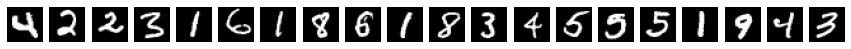

In [6]:
# Dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor() , download=True) # ToTensor() 每張照片0-255 -> 0-1 (標準化)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size = BATCH_SIZE, shuffle = False)
iterator = iter(train_loader)
images, labels = next(iterator)
fig, axes = plt.subplots(1,20, figsize=(15, 15))
for i in range(20):
  axes[i].imshow(images[i][0], cmap = 'gray')
  axes[i].set_axis_off()
fig.show()

In [13]:
class ConvNet(nn.Module):
  def __init__(self):
    super().__init__()
    """
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1) # 16x28x28  
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1) # 16x28x28
    self.pool1 = nn.MaxPool2d(2,2) # 16x14x14
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1) # 32x14x14
    self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1) # 32x14x14
    self.pool2 = nn.MaxPool2d(2,2) # 32x7x7  # height and width decrease, channels increase
    self.fc1 = nn.Linear(32*7*7,128) 
    self.fc2 = nn.Linear(128,10)
    """
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),  # 16x28x28  # ouput channels = 16 -> 16 filters
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1), # 16x28x28
        nn.ReLU(),
        nn.MaxPool2d(2, 2), # 16x14x14
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1), # 32x14x14
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1), # 32x14x14
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
    )
    # 拉直 -> 神經元
    self.fcs = nn.Sequential( 
        nn.Linear(32*7*7, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
  
  def forward(self, x):
    """
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool1(x)
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = self.pool2(x) # 64 x 32 x 7 x 7
    x = x.view(-1,32*7*7) # 64 x 1568 (拉直)
    x = F.relu(self.fc1(x))
    output = self.fc2(x)
    """
    x = self.conv(x)
    x = x.view(-1, 32*7*7)
    output = self.fcs(x)
    return output

In [14]:
cnn = ConvNet().to(device)
print(cnn)

ConvNet(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcs): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [16]:
# MNIST:6萬張照片 batch size:64 60000/64=938(1 epoch)
total_steps = len(train_loader)
for epoch in range(epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [64, 1, 28, 28]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = cnn(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad() # 梯度歸0 (對x做微分會一直累加, 但和上一個batch肯定不相關)
    loss.backward() # 梯度算gradient descent 
    optimizer.step() # 往前走一步 

    if (i+1) % 100 == 0:
      print (f'Epoch {epoch+1}, Step [{i+1}/{total_steps}], Loss: {loss.item():.4f}')

Epoch 1, Step [100/938], Loss: 1.8295
Epoch 1, Step [200/938], Loss: 0.7582
Epoch 1, Step [300/938], Loss: 0.5016
Epoch 1, Step [400/938], Loss: 0.3201
Epoch 1, Step [500/938], Loss: 0.3754
Epoch 1, Step [600/938], Loss: 0.2803
Epoch 1, Step [700/938], Loss: 0.2187
Epoch 1, Step [800/938], Loss: 0.0910
Epoch 1, Step [900/938], Loss: 0.2312
Epoch 2, Step [100/938], Loss: 0.1936
Epoch 2, Step [200/938], Loss: 0.2008
Epoch 2, Step [300/938], Loss: 0.1625
Epoch 2, Step [400/938], Loss: 0.2245
Epoch 2, Step [500/938], Loss: 0.1120
Epoch 2, Step [600/938], Loss: 0.1036
Epoch 2, Step [700/938], Loss: 0.1674
Epoch 2, Step [800/938], Loss: 0.0397
Epoch 2, Step [900/938], Loss: 0.0863
Epoch 3, Step [100/938], Loss: 0.1608
Epoch 3, Step [200/938], Loss: 0.0560
Epoch 3, Step [300/938], Loss: 0.1016
Epoch 3, Step [400/938], Loss: 0.1048
Epoch 3, Step [500/938], Loss: 0.1266
Epoch 3, Step [600/938], Loss: 0.0232
Epoch 3, Step [700/938], Loss: 0.0884
Epoch 3, Step [800/938], Loss: 0.1360
Epoch 3, Ste

In [22]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = cnn(images)

    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1) # 只要 index(預測分類), value(預測機率)不要
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item() # 64筆裡面以幾筆和label一樣

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')


Accuracy of the network: 98.87 %


# Parameters

In [23]:
for p in cnn.parameters():
  print(p)

Parameter containing:
tensor([[[[ 0.3463,  0.2325,  0.3740],
          [-0.1886, -0.1340,  0.1709],
          [-0.3146,  0.1113,  0.2362]]],


        [[[ 0.3759, -0.0614,  0.2793],
          [ 0.0345,  0.1504,  0.0620],
          [-0.3192,  0.0775,  0.2444]]],


        [[[-0.0576,  0.1991, -0.0623],
          [-0.0581,  0.2676,  0.3224],
          [ 0.3732,  0.1530, -0.1578]]],


        [[[-0.1692, -0.1209,  0.3697],
          [-0.1715, -0.0878, -0.1820],
          [-0.2093, -0.2761, -0.1611]]],


        [[[-0.0674,  0.1032, -0.0365],
          [ 0.3903,  0.1845,  0.3247],
          [ 0.4086, -0.1361, -0.1586]]],


        [[[-0.2143,  0.2648, -0.1210],
          [ 0.1781,  0.3657,  0.3596],
          [ 0.3371, -0.1752,  0.3453]]],


        [[[-0.3730, -0.1593, -0.3387],
          [ 0.1238, -0.2337, -0.0296],
          [-0.2492, -0.1985, -0.2679]]],


        [[[ 0.0532,  0.0490,  0.0088],
          [ 0.3192,  0.0842, -0.2367],
          [ 0.3910,  0.4578,  0.3688]]],


        [[

In [24]:
[p.numel() for p in cnn.parameters() if p.requires_grad]

[144, 16, 2304, 16, 4608, 32, 9216, 32, 200704, 128, 1280, 10]